In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from tqdm import tqdm
from transformers import MaskFormerFeatureExtractor, MaskFormerForInstanceSegmentation
import PIL
from PIL import Image
import requests
from transformers import pipeline
import datasets
from datasets import load_dataset
import os
import evaluate
import torch
import cv2
import json
import codecs
import matplotlib.lines as mlines

c:\Users\kuian\.conda\envs\master\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Visualize annotation

In [2]:
color_values = [
    [255, 255, 255],
    [0, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0]
]

plant_classification = {
    'void': 'void',
    'soil': 'soil',
    'broad bean': 'crop',
    'corn spurry': 'weed',
    'red-root amaranth': 'weed',
    'common buckwheat': 'crop',
    'pea': 'crop',
    'red fingergrass': 'weed',
    'common wild oat': 'weed',
    'cornflower': 'weed',
    'corn cockle': 'weed',
    'corn': 'crop',
    'milk thistle': 'weed',
    'rye brome': 'weed',
    'soybean': 'crop',
    'sunflower': 'crop',
    'narrow-leaved plantain': 'weed',
    'small-flower geranium': 'weed',
    'sugar beet': 'crop'
}

In [3]:
hex_colors = ['#{:02X}{:02X}{:02X}'.format(r, g, b) for r, g, b in color_values]
print(hex_colors)

['#FFFFFF', '#000000', '#008000', '#808000', '#000080', '#800080', '#008080', '#808080', '#400000', '#C00000', '#408000', '#C08000', '#400080', '#C00080', '#408080', '#C08080', '#004000', '#804000', '#00C000']


In [4]:
def get_legend():
    legend_elements = []
    for index, class_name in enumerate(plant_classification):
        element = mlines.Line2D([], [], color=hex_colors[index], marker='s', ls='', label=class_name)
        legend_elements.append(element)

    return legend_elements

In [22]:
def visualize_annotion(image_name):
    im = cv2.imread('./WE3DS/annotations/segmentation/SegmentationLabel/' + image_name)

    rgb = np.zeros_like(im)
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            index = im[i, j]    
            rgb[i, j] = color_values[index[0]]

    plt.axis('off')
    plt.legend(handles=get_legend(), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=9)
    plt.imshow(rgb)
    plt.show()

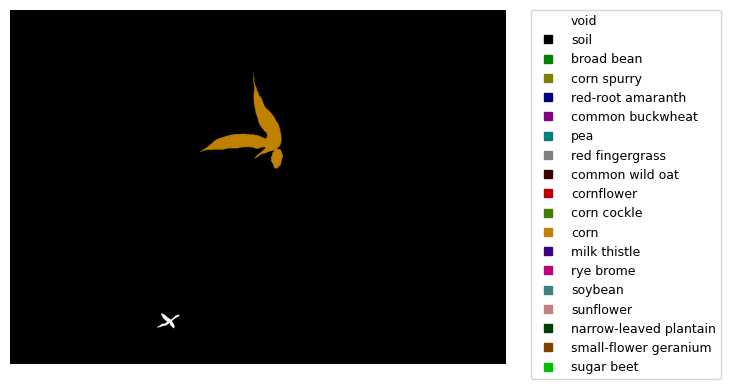

In [23]:
visualize_annotion('img_00000.png')

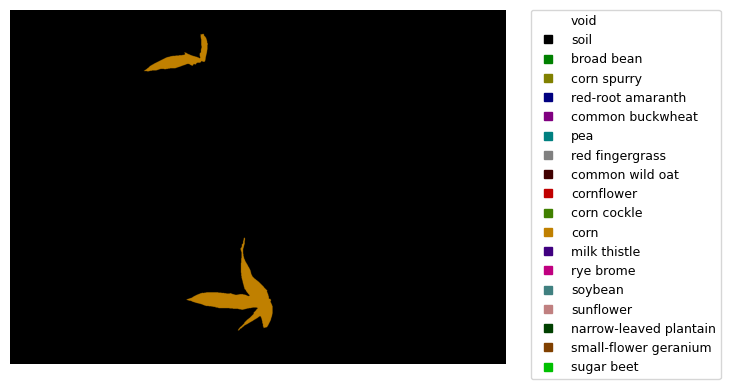

In [24]:
visualize_annotion('img_00001.png')

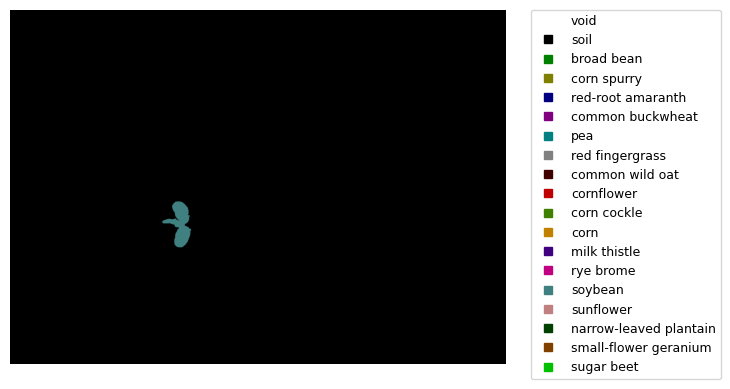

In [25]:
visualize_annotion('img_00045.png')